In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import ElectraTokenizer, ElectraForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
# ! pip install -U git+https://github.com/huggingface/transformers.git
# ! pip install -U git+https://github.com/huggingface/accelerate.git

In [2]:
# Define the custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        label = torch.tensor(self.labels[idx])
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': label
        }


In [3]:
import pandas as pd

In [4]:
train_data = pd.read_csv("/kaggle/input/nli-dataset-for-sentence-understanding/sst2_train.csv",error_bad_lines=False, engine="python")
test_data=pd.read_csv("/kaggle/input/nli-dataset-for-sentence-understanding/sst2_validation.csv",error_bad_lines=False , engine="python")
train_data.head()
# test_data.head()

/tmp/ipykernel_153/4041741829.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  train_data = pd.read_csv("/kaggle/input/nli-dataset-for-sentence-understanding/sst2_train.csv",error_bad_lines=False, engine="python")
/tmp/ipykernel_153/4041741829.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_data=pd.read_csv("/kaggle/input/nli-dataset-for-sentence-understanding/sst2_validation.csv",error_bad_lines=False , engine="python")


,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


In [5]:
train_data=train_data[["sentence","label"]]

test_data=test_data[["sentence","label"]]
test_data.head()

,sentence,label
0,it 's a charming and often affecting journey .,1
1,unflinchingly bleak and desperate,0
2,allows us to hope that nolan is poised to emba...,1
3,"the acting , costumes , music , cinematography...",1
4,"it 's slow -- very , very slow .",0


In [10]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=2)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [11]:
# Define the training and testing datasets
train_texts = train_data["sentence"]
train_labels = train_data["label"]
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)

test_texts = test_data["sentence"]
test_labels = test_data["label"]

In [12]:
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

In [14]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    cm = confusion_matrix(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1,"pred":pred,"conf":cm}

In [16]:
# Define Trainer
args = TrainingArguments(
    output_dir="/kaggle/working/output",
    num_train_epochs=1,
    per_device_train_batch_size=8

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,0.445100
1000,0.324900
1500,0.292800
2000,0.260000
2500,0.253100
3000,0.232700
3500,0.238100
4000,0.218600


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=4210, training_loss=0.2799774921988082, metrics={'train_runtime': 642.5738, 'train_samples_per_second': 104.811, 'train_steps_per_second': 6.552, 'total_flos': 495345847598592.0, 'train_loss': 0.2799774921988082, 'epoch': 1.0})

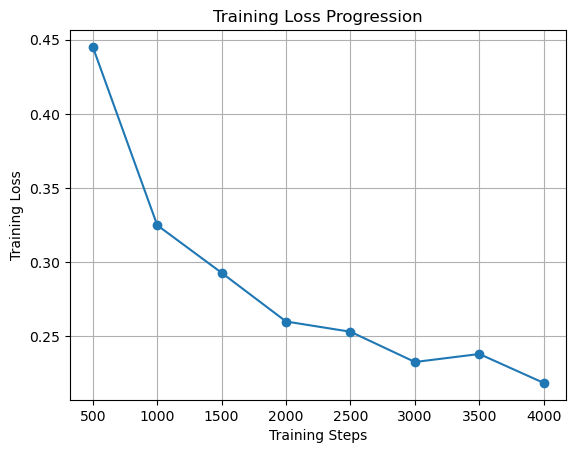

In [26]:
import matplotlib.pyplot as plt

# Training loss data
steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
losses = [0.445100, 0.324900, 0.292800, 0.260000, 0.253100, 0.232700, 0.238100, 0.218600]

# Plotting the training loss
plt.plot(steps, losses, marker='o')
plt.xlabel('Training Steps')
plt.ylabel('Training Loss')
plt.title('Training Loss Progression')
plt.grid(True)
plt.show()

In [24]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
evaluation = trainer.predict(test_dataset)

<class 'transformers.trainer_utils.EvalPrediction'>


In [27]:
print(evaluation)

PredictionOutput(predictions=array([[-2.8027072,  3.2610693],
       [ 1.8949544, -2.2970831],
       [-2.1701026,  2.3335435],
       ...,
       [ 1.4568942, -1.8153208],
       [ 1.693336 , -2.0789666],
       [-2.7158792,  3.0922616]], dtype=float32), label_ids=array([1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
    

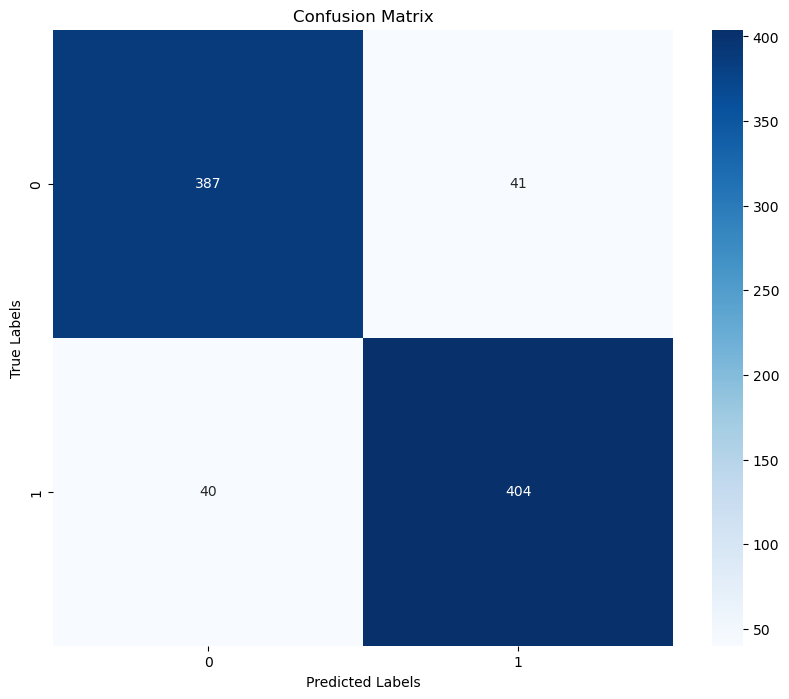

In [25]:
# Access the confusion matrix from the evaluation results
confusion_matrix = evaluation.metrics["test_conf"]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()